In [3]:
# %load ../start.py
# Imports
import os
import sys
import csv
import string
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy.stats as stats
import scipy.io
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../../lib')
from larval_gonad.notebook import Nb
from larval_gonad.plotting import make_figs, TSNEPlot

# Setup notebook
nbconfig = Nb.setup_notebook('2017-11-29_scRNAseq_combined_ovary_and_testis')

# Turn on cache
from joblib import Memory
memory = Memory(cachedir=nbconfig.cache, verbose=0)

%reload_ext rpy2.ipython

last updated: 2017-12-01 
Git hash: be0a0f4e40f554797ae36ff599f59180bf69efa6


In [2]:
REF = os.environ['REFERENCES_DIR']
CHROMS = ['chrX', 'chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4']
BRIAN = ['dj', 'ocn', 'CG10920', 'boil', 'CG1314']  # CG12681 is not called boil

# Create fbgn2symbol and symbol2fbgn map
annot = pd.read_csv(Path(REF, 'dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation'),
                   sep='\t', index_col=1)

fbgn2symbol = annot['gene_symbol'].to_dict()
symbol2fbgn = {v: k for k, v in fbgn2symbol.items()}

# Create fbgn2chrom
genes = []
with Path(REF, 'dmel/r6-16/gtf/dmel_r6-16.gtf').open() as fh:
    for row in fh:
        rows = row.strip().split()
        
        if len(rows) == 0:
            continue
            
        if rows[2] == 'gene':
            genes.append((rows[0], rows[9].replace('"', '').replace(';', '')))

fbgn2chrom = pd.DataFrame(genes, columns=['chrom', 'FBgn'])
fbgn2chrom.set_index('FBgn', inplace=True)
fbgn2chrom = fbgn2chrom[fbgn2chrom['chrom'].isin(CHROMS)]

In [3]:
# Read in data and make giant matrix
def parse_matrix(tissue):
    genome = "dm6.16"
    matrix_dir = Path(f"../../output/{tissue}1/outs/filtered_gene_bc_matrices", genome)
    mat = scipy.io.mmread(str(matrix_dir / "matrix.mtx"))
    genes = [row[0] for row in csv.reader((matrix_dir / 'genes.tsv').open(), delimiter="\t")]
    cells = [row[0].replace('1', tissue) for row in csv.reader((matrix_dir / 'barcodes.tsv').open(), delimiter="\t")]
    return pd.DataFrame(mat.todense(), index=genes, columns=cells)

dfOvary = parse_matrix('ovary')
dfTestis = parse_matrix('testis')

df = dfOvary.join(dfTestis)

In [4]:
%%R -i df -o meta_data
# Import R libraries
.libPaths("/data/fearjm/miniconda3/envs/larval_gonad/lib/R/library")
library(Seurat)
library(dplyr)
library(Matrix)

combined = CreateSeuratObject(df, min.cells=3, min.genes=200, project='10X_combined')

# Add tissue metadata
combined@meta.data[grepl('ovary', rownames(combined@meta.data)), 'tissue'] = 'ovary'
combined@meta.data[grepl('testis', rownames(combined@meta.data)), 'tissue'] = 'testis'

meta_data = combined@meta.data

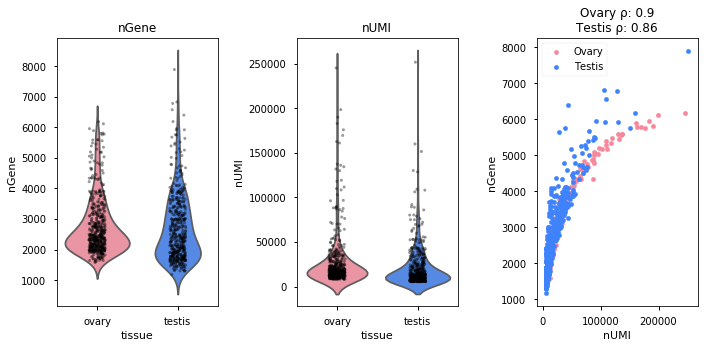

In [5]:
@make_figs(nbconfig.fig_name('nGene_nUMI_panel'), 
           styles=nbconfig.styles, formats=nbconfig.formats)
def plot_nGene_nUMI_panel():
    _ov = meta_data.tissue == 'ovary'
    _te = meta_data.tissue == 'testis'

    # Plot distribution of gene counts and UMI counts
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    
    sns.violinplot(x='tissue', y='nGene', data=meta_data, inner=None, ax=ax1, palette=nbconfig.colors_sex)
    sns.stripplot(x='tissue', y='nGene', data=meta_data, color='k', jitter=1.0, size=3, alpha=.4, ax=ax1)
    
    sns.violinplot(x='tissue', y='nUMI', data=meta_data, inner=None, ax=ax2, palette=nbconfig.colors_sex)
    sns.stripplot(x='tissue', y='nUMI', data=meta_data, color='k', jitter=1.0, size=3, alpha=.4, ax=ax2)

    mapper = {'ovary': nbconfig.color_female, 'testis': nbconfig.color_male}
    rho = {}
    for g, df in meta_data.groupby('tissue'):
        df.plot.scatter('nUMI', 'nGene', c=mapper[g], ax=ax3, label=g.title())
        rho[g] = np.round(stats.pearsonr(df.nGene, df.nUMI)[0], 2)
    ax3.legend()

    ax1.set_title('nGene')
    ax2.set_title('nUMI')
    ax3.set_title('Ovary ρ: {ovary}\nTestis ρ: {testis}'.format(**rho))
    plt.tight_layout()

plot_nGene_nUMI_panel()

In [6]:
%%R -o norm -o dispersion
combined = FilterCells(object=combined, subset.names=c("nGene"), low.thresholds=c(200), high.thresholds=c(6000))
combined = NormalizeData(object=combined, normalization.method="LogNormalize", scale.factor=1e4)
norm = as.data.frame(as.matrix(combined@data))

# Detection of variable genes across the single cells
combined = FindVariableGenes(object=combined, 
                           mean.function=ExpMean, 
                           dispersion.function=LogVMR, 
                           x.low.cutoff=0.01, 
                           x.high.cutoff=3, 
                           y.cutoff=0.5,
                           y.high.cutoff=Inf,
                           do.plot=FALSE
                          )

dispersion = combined@hvg.info

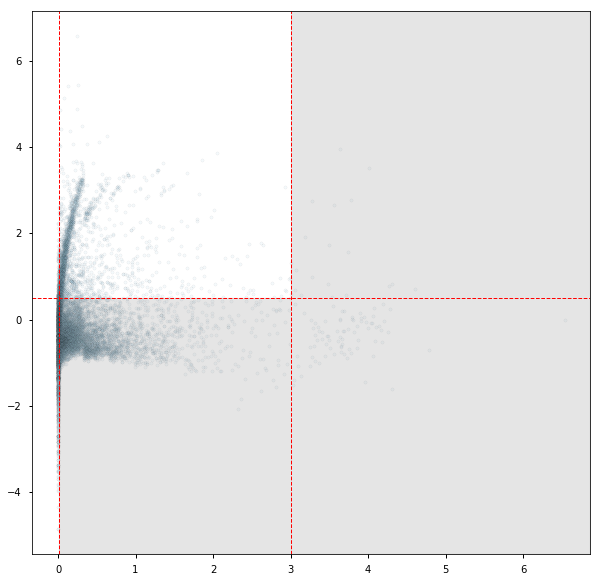

In [7]:
def plot_dispersion():
    _x_low = 0.01
    _x_high = 3
    _y_low = 0.5

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.scatter(dispersion['gene.mean'], dispersion['gene.dispersion.scaled'], 
                s=10, alpha=.1, edgecolor='k')
    ax.axvline(_x_low, ls='--', lw=1, color='r')
    ax.axvline(_x_high, ls='--', lw=1, color='r')
    ax.axhline(_y_low, ls='--', lw=1, color='r')

    _x_min, _x_max = ax.get_xlim()
    _y_min, _y_max = ax.get_ylim()

    verts = [
        [_x_low, _y_min], 
        [_x_low, _y_low], 
        [_x_high, _y_low], 
        [_x_high, _y_max],
        [_x_max, _y_max],
        [_x_max, _y_min],
    ]
    p1 = mpl.patches.Polygon(verts, color='grey', alpha=.2)
    ax.add_patch(p1)
    
plot_dispersion()

In [8]:
%%R -o pca_res -o gene_loadings
# Scaling the data and removing unwanted sources of variation
combined = ScaleData(object=combined, vars.to.regress=c("nUMI"))

# Perform linear dimensional reduction
combined = RunPCA(object=combined, pc.genes=combined@var.genes, do.print=FALSE, pcs.compute=100)

# ProjectPCA scores each gene in the dataset (including genes not included in the PCA) based on their correlation
# with the calculated components. Though we don't use this further here, it can be used to identify markers that
# are strongly correlated with cellular heterogeneity, but may not have passed through variable gene selection.
# The results of the projected PCA can be explored by setting use.full=T in the functions above
combined = ProjectPCA(object=combined, do.print=FALSE)

pca_res = as.data.frame(combined@dr$pca@cell.embeddings)
gene_loadings = as.data.frame(combined@dr$pca@gene.loadings)

[1] "Regressing out nUMI"
  |======================================================================| 100%
[1] "Scaling data matrix"
  |======================================================================| 100%


Text(0,0.5,'PC2')

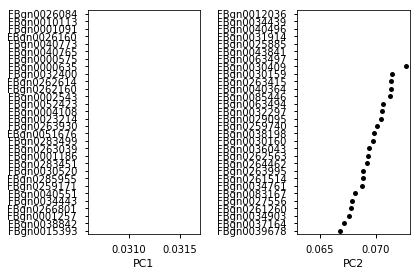

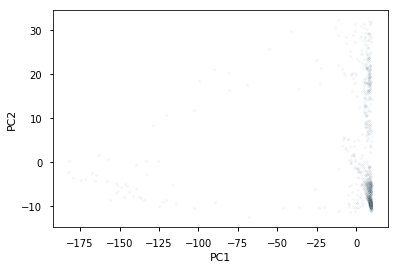

In [9]:
def plot_pca():
    pc1 = gene_loadings.PC1.sort_values(ascending=False).head(30).reset_index()
    pc2 = (gene_loadings.PC2 * -1).sort_values(ascending=False).head(30).reset_index()

    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.stripplot(x="PC1", y="index", data=pc1, ax=ax1, color='k')
    ax1.set_xlim(0.0306, 0.0317)
    ax1.set_ylabel('')

    sns.stripplot(x="PC2", y="index", data=pc2, ax=ax2, color='k')
    ax2.set_xlim(0.063, 0.073)
    ax2.set_ylabel('')
    plt.tight_layout()

    fig, ax = plt.subplots(1, 1)
    ax.scatter(pca_res.PC1, -1 * pca_res.PC2, alpha=.1, s=3, edgecolor='k')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    
plot_pca()

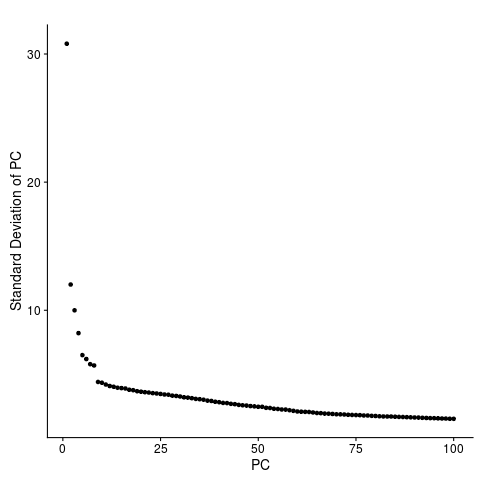

In [10]:
%%R
### Determine statistically significant principal components
PCElbowPlot(object=combined, num.pc=100)

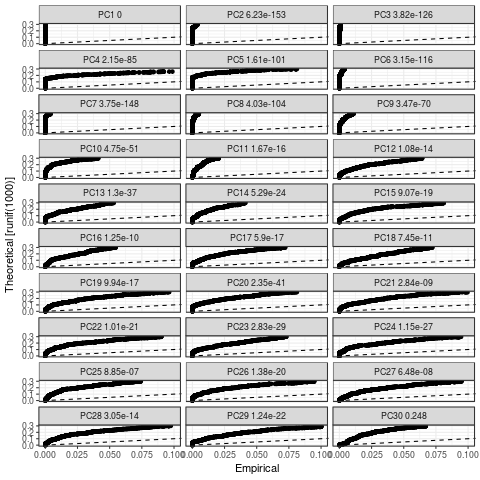

In [11]:
%%R
combined = JackStraw(object=combined, num.replicate=100, do.print=FALSE, num.pc=50)
JackStrawPlot(object=combined, PCs=1:30)

In [12]:
%%R -o ident
combined = FindClusters(object=combined, reduction.type="pca", dims.use=1:30, 
                      resolution=0.6, print.output=0, save.SNN=TRUE)

# Grab cluster identities
ident = as.data.frame(combined@ident)
colnames(ident) = c('ident')

PrintFindClustersParams(object=combined)
# While we do provide function-specific printing functions, the more general function to
# print calculation parameters is PrintCalcParams().

Parameters used in latest FindClusters calculation run on: 2017-12-01 08:46:43
Resolution: 0.6
-----------------------------------------------------------------------------
Modularity Function    Algorithm         n.start         n.iter
     1                   1                 100             10
-----------------------------------------------------------------------------
Reduction used          k.param          k.scale          prune.SNN
     pca                 30                25              0.0667
-----------------------------------------------------------------------------
Dims used in calculation
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
30



In [13]:
%%R -o tsne
### Run Non-linear dimensional reduction (tSNE)
combined = RunTSNE(object=combined, dims.use=1:80, do.fast=TRUE)
tsne = as.data.frame(combined@dr$tsne@cell.embeddings)

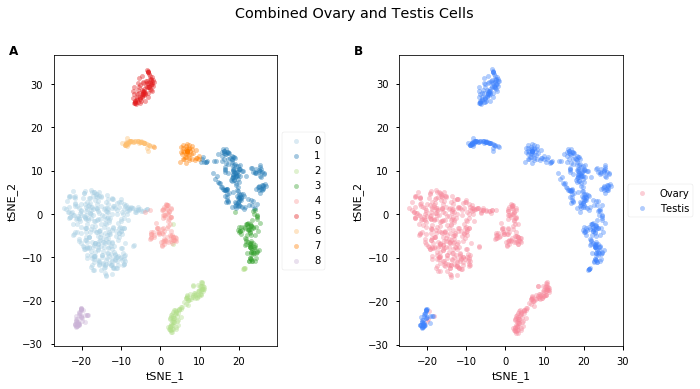

In [86]:
@make_figs(nbconfig.fig_name('combined_tSNE'), [x + '-wide' for x in nbconfig.styles], 
           nbconfig.formats, kws_layout={'w_pad': 6, 'rect': [0, 0, .9, .9]})
def plot_combined_tSNE():
    fig, (ax1, ax2) = plt.subplots(1, 2)
    _df = tsne.join(ident).join(meta_data)

    TSNEPlot('tSNE_1', 'tSNE_2', data=_df, hue='ident', 
             palette=nbconfig.colors, ax=ax1, alpha=.4)

    TSNEPlot('tSNE_1', 'tSNE_2', data=_df, hue='tissue', 
             palette=nbconfig.colors_sex, ax=ax2, alpha=.4)

    ax1.text(-.2, 1, 'A', fontweight='bold', fontsize=12, transform=ax1.transAxes)
    ax2.text(-.2, 1, 'B', fontweight='bold', fontsize=12, transform=ax2.transAxes)
    fig.suptitle('Combined Ovary and Testis Cells');

plot_combined_tSNE()

In [116]:
def plot_gene(symbol=None, fbgn=None, **kwargs):
    if symbol is None:
        symbol = fbgn2symbol[fbgn]

    if fbgn is None:
        fbgn = symbol2fbgn[symbol]

    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1.2, 1]})
    _df = tsne.join(norm.T.copy()[fbgn])
    TSNEPlot('tSNE_1', 'tSNE_2', data=_df, hue=fbgn, s=10, 
             ax=ax1, title='Normalized Expression\n(Continuous)', **kwargs)

    TSNEPlot('tSNE_1', 'tSNE_2', data=_df, hue=_df[fbgn] > 0, 
             cmap={
                 '0': sns.xkcd_rgb['light grey'],
                 '1': 'k',
             }, s=10, ax=ax2, alpha=0.4,  title='Normalized Expression\n(Binary)', **kwargs)

    fig.suptitle(f'{symbol} ({fbgn})');
    
@make_figs(nbconfig.fig_name('gene_tSNE'), [x + '-wide' for x in nbconfig.styles], 
           nbconfig.formats, kws_layout={'w_pad': 6, 'rect': [0, 0, .9, .9]})
def _plot_gene(*args, **kwargs):
    plot_gene(*args, **kwargs)

In [140]:
def iter_plot(fbgns, pth=Path('../../output/figures/combined_pilot_tsne')):
    pth.mkdir(exist_ok=True)
    
    if isinstance(fbgns, str):
        fbgns = [fbgns]
    
    def sanitize_fname(fname):
        valid_chars = "-_.%s%s" % (string.ascii_letters, string.digits)
        return ''.join([x for x in fname if x in valid_chars])

    for fbgn in fbgns:
        gene = fbgn2symbol[fbgn]
        _gene = sanitize_fname(gene)
        fname = f'{_gene}_{fbgn}'
        if (pth / fname, )
        
        @make_figs(str(pth / fname), ['talk-wide', 'paper-wide'], 
                   ['png', 'pdf'], kws_layout={'w_pad': 6, 'rect': [0, 0, .9, .9]})
        def _plot_gene(*args, **kwargs):
            plot_gene(*args, **kwargs)
            
        _plot_gene(symbol=gene, fbgn=fbgn)
        plt.close()

In [176]:
fbgns = norm[((norm > 0).sum(axis=1) > 10)].index.tolist()

In [ ]:
iter_plot(fbgns)

In [4]:
pth = Path('/home/bob')

In [13]:
pth / ('dan' '.bob')

PosixPath('/home/bob/dan.bob')

In [44]:
%%R -o combined_markers
combined_markers = FindAllMarkers(combined, only.pos=TRUE, min.pct = 0.25, thresh.use = 0.25)
rownames(combined_markers) = NULL

   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 01m 07s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 01m 44s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 43s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 01m 12s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 29s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 01m 09s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 02m 53s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 04m 10s
   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed = 01m 47s


In [150]:
# export table with cluster 8 values

#pull out biomarkers for cluster 8
combined_markers['symbol'] = combined_markers['gene'].apply(lambda x: fbgn2symbol[x])
clus8 = combined_markers[(combined_markers.cluster == '8') & \
                        (combined_markers.p_val_adj < 1e-4)].sort_values(
    'avg_logFC', ascending=False)

# Get meta_data and normalized counts for cluster 8
c8idx = ident[ident.ident == '8'].index
c8meta = meta_data[meta_data.index.isin(c8idx)]

c8cnt = c8meta['tissue'].to_frame().join(norm.T).groupby('tissue').count()
c8exp = c8meta['tissue'].to_frame().join(norm.T).groupby('tissue').mean()

# Build up table with DEG, avg expression, and metadata
table = clus8.merge(
    c8exp[clus8.gene].T, left_on='gene', right_index=True
).merge(
    c8cnt[clus8.gene].T, left_on='gene', right_index=True, 
    suffixes=['_avg_exp', '_num_cells']
)

header = [
    'gene', 'symbol',  'cluster',  'ovary_num_cells',
    'ovary_avg_exp',  'testis_num_cells', 'testis_avg_exp', 
    'pct.1',  'pct.2',  'avg_logFC',  'p_val',  'p_val_adj'
]

table[header].to_csv('../../output/ovary_testis_merge_cluster8.tsv', sep='\t', index=False)